In [8]:
import pandas as pd
import numpy as np

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [9]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [10]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [58.00, 58.00]


In [11]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


In [12]:
# gerando dados aleatorios de modelo de carro para simulacao de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [13]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [14]:
# GroupKFold em um pipeline com StandardScaler e SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.68
Intervalo [74.28, 79.08]


In [15]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


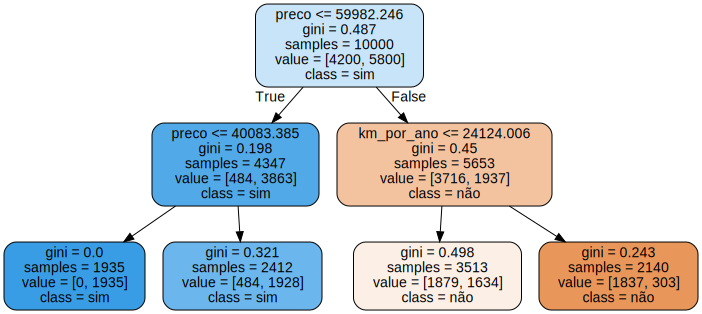

In [16]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, 
                            class_names=['não', 'sim'], 
                            feature_names=features)
graph = graphviz.Source(dot_data)
graph

In [17]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 78.67
Intervalo [76.40, 80.94]


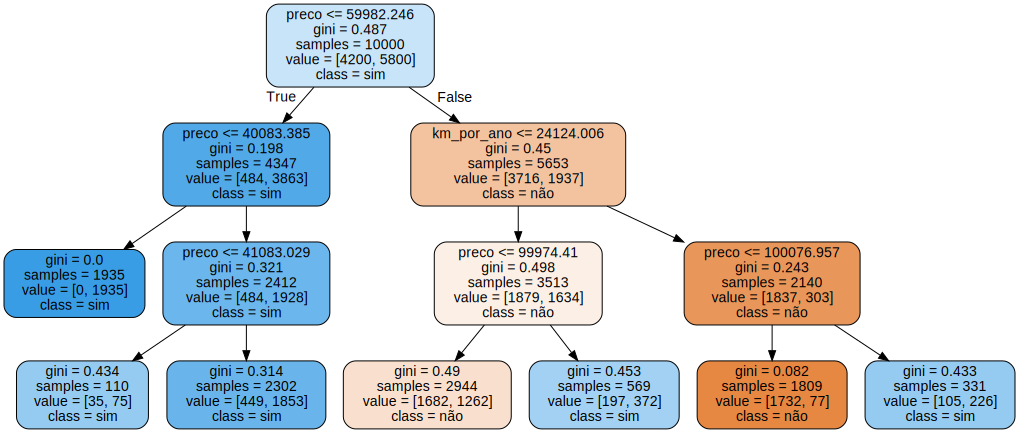

In [18]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, 
                            class_names=['não', 'sim'], 
                            feature_names=features)
graph = graphviz.Source(dot_data)
graph

## Explorando Hiperparâmetros em uma dimensão

In [19]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

def roda_arvore_de_decisao(max_depth):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100
    print("Arvore max_depth = %d, treino = %.2f, teste = %.2f," % (max_depth, results['train_score'].mean() * 100, results['test_score'].mean() * 100))
    tabela = [max_depth, train_score, test_score]
    return tabela


#list comprehension
resultados = [roda_arvore_de_decisao(i) for i in range (1,33)]
resultados = pd.DataFrame(resultados, columns=['max_depth', 'train', 'test'])
resultados.head()

Arvore max_depth = 1, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, treino = 75.79, teste = 75.78,
Arvore max_depth = 3, treino = 78.75, teste = 78.67,
Arvore max_depth = 4, treino = 78.79, teste = 78.63,
Arvore max_depth = 5, treino = 78.94, teste = 78.56,
Arvore max_depth = 6, treino = 79.17, teste = 78.12,
Arvore max_depth = 7, treino = 79.50, teste = 77.96,
Arvore max_depth = 8, treino = 79.89, teste = 77.86,
Arvore max_depth = 9, treino = 80.46, teste = 77.38,
Arvore max_depth = 10, treino = 81.16, teste = 77.19,
Arvore max_depth = 11, treino = 82.03, teste = 76.97,
Arvore max_depth = 12, treino = 82.89, teste = 76.49,
Arvore max_depth = 13, treino = 83.95, teste = 75.81,
Arvore max_depth = 14, treino = 85.03, teste = 75.66,
Arvore max_depth = 15, treino = 86.14, teste = 75.16,
Arvore max_depth = 16, treino = 87.19, teste = 75.11,
Arvore max_depth = 17, treino = 88.31, teste = 74.74,
Arvore max_depth = 18, treino = 89.26, teste = 74.33,
Arvore max_depth = 19, treino = 90.32

,max_depth,train,test
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912


### Overfit: ficou 'perfeito' para o treino, mas ruim para teste

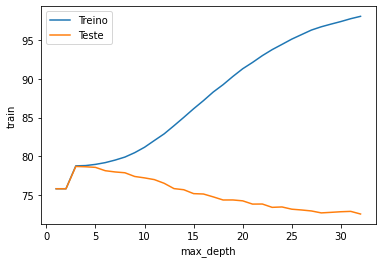

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=resultados, x='max_depth', y='train')
sns.lineplot(data=resultados, x='max_depth', y='test')
plt.legend(['Treino', 'Teste'])

In [21]:
resultados.sort_values('test', ascending=False).head()

,max_depth,train,test
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185


## Explorando Hiperparâmetros em duas dimensões

In [22]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

def roda_arvore_de_decisao(max_depth, min_samples_leaf):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100
    print("Arvore max_depth = %d, min_samples_leaf = %d, treino = %.2f, teste = %.2f," % (max_depth, min_samples_leaf, results['train_score'].mean() * 100, results['test_score'].mean() * 100))
    tabela = [max_depth, min_samples_leaf, train_score, test_score]
    return tabela


def busca():
    resultados = []
    for max_depth in range(1, 33):
        for min_samples_leaf in [32, 64, 128, 256]:
            tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
            resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns=['max_depth', 'min_samples_leaf', 'train', 'test'])
    return resultados

In [23]:
resultados = busca()

Arvore max_depth = 1, min_samples_leaf = 32, treino = 75.79, teste = 75.78,
Arvore max_depth = 1, min_samples_leaf = 64, treino = 75.79, teste = 75.78,
Arvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78,
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, min_samples_leaf = 32, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, min_samples_leaf = 64, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78,
Arvore max_depth = 3, min_samples_leaf = 32, treino = 78.75, teste = 78.67,
Arvore max_depth = 3, min_samples_leaf = 64, treino = 78.75, teste = 78.67,
Arvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.67,
Arvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.67,
Arvore max_depth = 4, min_samples_leaf = 32, treino = 78.75, teste = 78.67,
Arvore

In [24]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
15,4,256,78.750993,78.672633
12,4,32,78.750993,78.672633
14,4,128,78.750993,78.672633
13,4,64,78.750993,78.672633
8,3,32,78.750993,78.672633


In [25]:
corr = resultados.corr()

<AxesSubplot:>

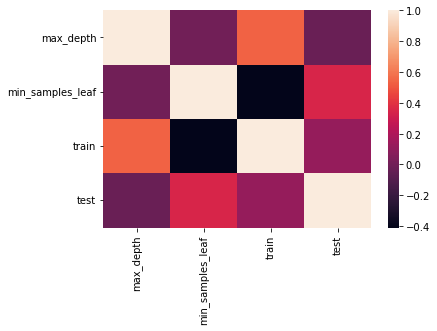

In [26]:
sns.heatmap(corr)

array([[<AxesSubplot:xlabel='max_depth', ylabel='max_depth'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='max_depth'>,
        <AxesSubplot:xlabel='train', ylabel='max_depth'>,
        <AxesSubplot:xlabel='test', ylabel='max_depth'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='train', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='test', ylabel='min_samples_leaf'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='train'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='train'>,
        <AxesSubplot:xlabel='train', ylabel='train'>,
        <AxesSubplot:xlabel='test', ylabel='train'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='test'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='test'>,
        <AxesSubplot:xlabel='train', ylabel='test'>,
        <AxesSubplot:xlabel='test', ylabel='test'>]], dtype=object)

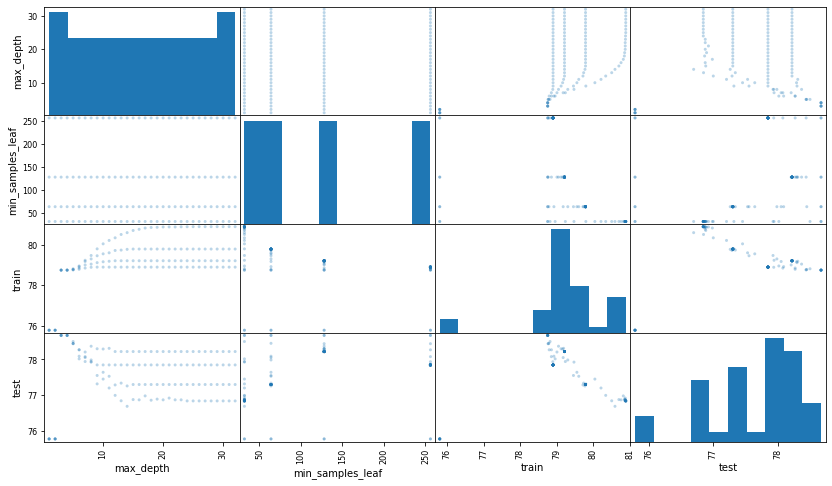

In [27]:
pd.plotting.scatter_matrix(resultados, figsize = (14,8), alpha = 0.3)

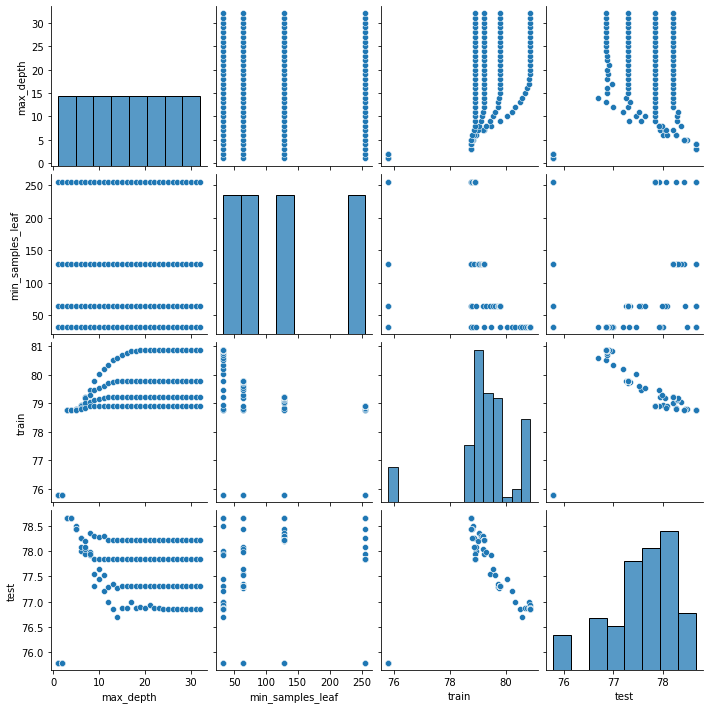

In [28]:
sns.pairplot(resultados)

/tmp/ipykernel_5156/1569857682.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

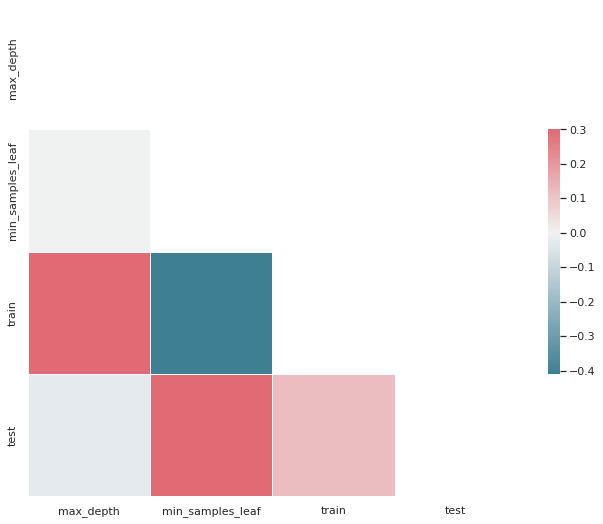

In [29]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [30]:
def busca():
    resultados = []
    for max_depth in range(1, 33):
        for min_samples_leaf in [128, 192, 256, 512]:
            tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
            resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns=['max_depth', 'min_samples_leaf', 'train', 'test'])
    return resultados

resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78,
Arvore max_depth = 1, min_samples_leaf = 192, treino = 75.79, teste = 75.78,
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78,
Arvore max_depth = 1, min_samples_leaf = 512, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, min_samples_leaf = 192, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, min_samples_leaf = 512, treino = 75.79, teste = 75.78,
Arvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.67,
Arvore max_depth = 3, min_samples_leaf = 192, treino = 78.75, teste = 78.67,
Arvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.67,
Arvore max_depth = 3, min_samples_leaf = 512, treino = 77.53, teste = 77.50,
Arvore max_depth = 4, min_samples_leaf = 128, treino = 78.75, teste = 78.67,

,max_depth,min_samples_leaf,train,test
0,1,128,75.791169,75.784219
1,1,192,75.791169,75.784219
2,1,256,75.791169,75.784219
3,1,512,75.791169,75.784219
4,2,128,75.791169,75.784219


In [31]:
corr = resultados.corr()

/tmp/ipykernel_5156/1569857682.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

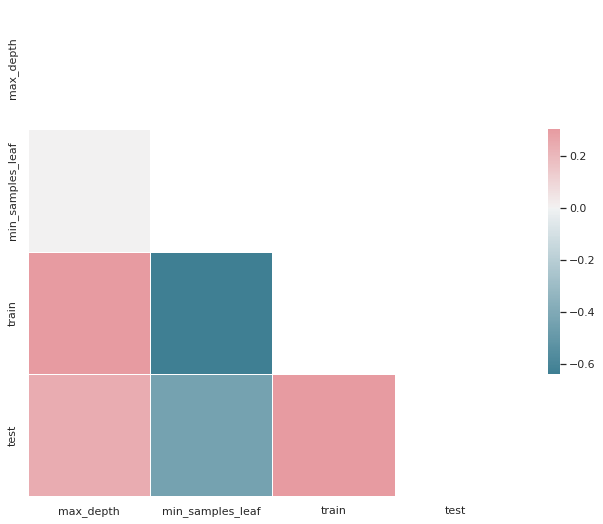

In [32]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [33]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
13,4,192,78.750993,78.672633
8,3,128,78.750993,78.672633
9,3,192,78.750993,78.672633
10,3,256,78.750993,78.672633
14,4,256,78.750993,78.672633


## Explorando Hiperparâmetros com três dimensões

In [34]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    fit_time = results['fit_time'].mean()
    score_time = results['score_time'].mean()
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100
    tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
    return tabela


def busca():
    resultados = []
    for max_depth in range(1, 33):
        for min_samples_leaf in [32, 64, 128, 256]:
            for min_samples_split in [32, 64, 128, 256]:
                tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
                resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns=['max_depth', 'min_samples_leaf', 'min_samples_split', 'train', 'test', 'fit_time', 'score_time'])
    return resultados

In [35]:
resultados = busca()
resultados.head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,32,32,75.791169,75.784219,0.004519,0.001548
1,1,32,64,75.791169,75.784219,0.003970,0.001253
2,1,32,128,75.791169,75.784219,0.011206,0.001232
3,1,32,256,75.791169,75.784219,0.003850,0.001285
4,1,64,32,75.791169,75.784219,0.003856,0.001265


/tmp/ipykernel_5156/1709128675.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

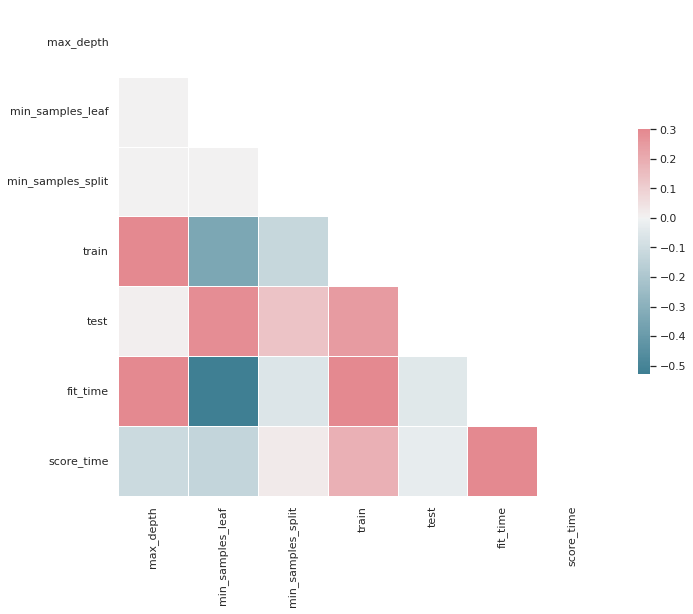

In [36]:
corr = resultados.corr()
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [37]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
63,4,256,256,78.750993,78.672633,0.008265,0.001376
48,4,32,32,78.750993,78.672633,0.008433,0.001342
34,3,32,128,78.750993,78.672633,0.007366,0.001391
35,3,32,256,78.750993,78.672633,0.007125,0.001364
36,3,64,32,78.750993,78.672633,0.006960,0.001214


## Utilizando Grid Search CV

In [38]:
from sklearn.model_selection import GridSearchCV

In [39]:
SEED = 301
np.random.seed(SEED)

espaco_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "criterion" : ["gini", "entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_parametros,
                    cv = GroupKFold(n_splits=10))

busca.fit(x_azar, y_azar, groups=dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007098,0.000534,0.001339,0.000260,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.006815,0.000045,0.001151,0.000052,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.006618,0.000100,0.001062,0.000053,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.006592,0.000218,0.001100,0.000081,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.006645,0.000370,0.001091,0.000093,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [40]:
print(busca.best_params_)
print(busca.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67263337284332


In [41]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

In [42]:
from sklearn.metrics import accuracy_score

# evitar essa abordagem pois estará sendo otimista
predicoes = melhor.predict(x_azar)
accuracy = accuracy_score(predicoes, y_azar) * 100
print("Accuracy para os dados foi %.2f" % accuracy)

Accuracy para os dados foi 78.75


## Como ter uma estimativa sem esse vício nos dados que eu já vi?
No caso de CV com busca de hiperparametros, fazemos uma nova validação cruzada. Chama-se nested cross validation

In [43]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = GroupKFold(n_splits=10), groups = dados.modelo)

# Infelizmente como o Pandas não suporta nested validation com group K fold, não conseguimos prever o resutlado para novos grupos

/home/laryssastephanie/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/laryssastephanie/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/laryssastephanie/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 891, in fit
    self._run_search(evaluate_candidates)
  File "/home/laryssastephanie/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py", lin

In [44]:
from sklearn.model_selection import KFold
SEED = 301
np.random.seed(SEED)

espaco_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "criterion" : ["gini", "entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_parametros,
                    cv = KFold(n_splits=5, shuffle=True))

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006640,0.000230,0.001437,0.000259,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.006156,0.000037,0.001186,0.000047,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.006269,0.000145,0.001193,0.000102,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.006092,0.000149,0.001147,0.000031,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.005859,0.000072,0.001155,0.000072,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


In [45]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
scores

array([0.7895, 0.7825, 0.7905, 0.7715, 0.7995])

In [46]:
def imprime_score(scores):
  media = scores.mean() * 100
  desvio = scores.std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [47]:
imprime_score(scores)

Accuracy médio 78.67
Intervalo [76.80, 80.54]


In [48]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

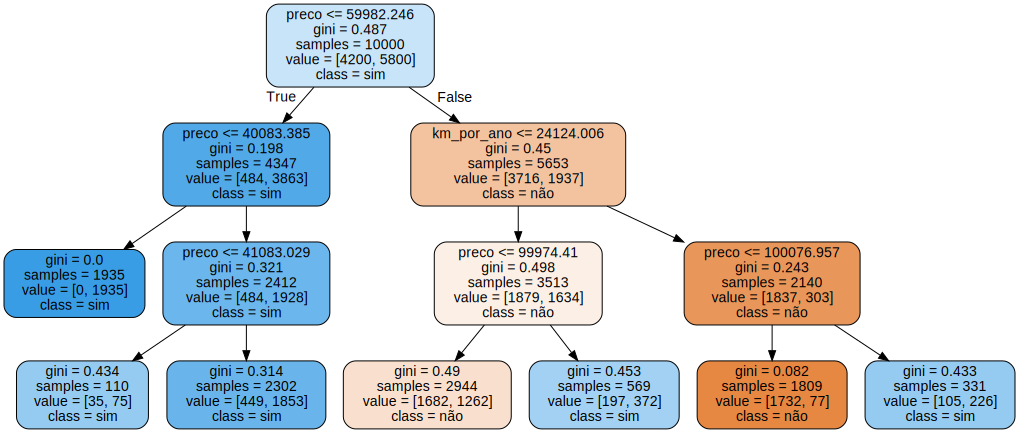

In [49]:
features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True, 
                            class_names=['não', 'sim'], 
                            feature_names=features)
graph = graphviz.Source(dot_data)
graph

## Curso: Otimização com Exploração Aleatória - Formação Machine Learning

Randomized Search e Cross Validation

In [50]:
from sklearn.model_selection import RandomizedSearchCV
SEED = 301
np.random.seed(SEED)

espaco_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "criterion" : ["gini", "entropy"]
}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_parametros,
                    n_iter=16,              # tenho 36 opções no grid search (2*3*3*2). Mas no randomized escolho quantos aleatórios quero pegar através do n_iter
                    cv = KFold(n_splits=5, shuffle=True),
                    random_state=SEED)

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009657,0.001831,0.001945,0.000530,128,128,5,gini,"{'min_samples_split': 128, 'min_samples_leaf':...",0.784,0.769,0.7985,0.793,0.7730,0.7835,0.011278,13
1,0.006595,0.000295,0.001475,0.000159,64,32,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.776,0.8025,0.793,0.7795,0.7870,0.009618,1
2,0.006704,0.000397,0.001616,0.000374,64,128,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.776,0.8025,0.793,0.7795,0.7870,0.009618,1
3,0.014261,0.004754,0.002361,0.001366,32,64,5,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.784,0.769,0.8005,0.793,0.7730,0.7839,0.011825,7
4,0.010978,0.000339,0.001578,0.000141,64,64,5,entropy,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.769,0.8005,0.793,0.7730,0.7839,0.011825,7


In [51]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
scores

array([0.7825, 0.783 , 0.794 , 0.781 , 0.795 ])

In [52]:
imprime_score(scores)

Accuracy médio 78.71
Intervalo [77.49, 79.93]


In [53]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=64)

### Customizando o espaço de hiper parâmetros

In [54]:
from scipy.stats import randint

SEED = 301
np.random.seed(SEED)

espaco_parametros = {
    "max_depth" : [3, 5, 10, 15, 20, 30, None],
    "min_samples_split" : randint(32, 128),
    "min_samples_leaf" : randint(32, 128),
    "criterion" : ["gini", "entropy"]
}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_parametros,
                    n_iter=16,              # tenho 36 opções no grid search (2*3*3*2). Mas no randomized escolho quantos aleatórios quero pegar através do n_iter
                    cv = KFold(n_splits=5, shuffle=True),
                    random_state=SEED)

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008559,0.001729,0.001778,0.000699,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7840,0.7760,0.8025,0.7930,0.7795,0.7870,0.009618,1
1,0.012192,0.000560,0.001625,0.000188,gini,15,93,111,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7740,0.7725,0.7830,0.7805,0.7725,0.7765,0.004393,14
2,0.011653,0.001108,0.001574,0.000199,gini,20,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7705,0.7745,0.7990,0.7790,0.7735,0.7793,0.010221,8
3,0.016096,0.001426,0.001736,0.000317,gini,None,46,62,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7575,0.7730,0.7725,0.7835,0.7560,0.7685,0.010378,16
4,0.011494,0.000982,0.001585,0.000080,gini,15,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7705,0.7735,0.7995,0.7790,0.7745,0.7794,0.010413,7


In [56]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_score(scores)

Accuracy médio 78.70
Intervalo [76.85, 80.55]


In [57]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=71,
                       min_samples_split=100)

In [67]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media.iterrows():
    print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.787 +-(0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
0.784 +-(0.024) {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 73, 'min_samples_split': 72}
0.784 +-(0.024) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
0.781 +-(0.017) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 108, 'min_samples_split': 110}
0.780 +-(0.019) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 125, 'min_samples_split': 59}
0.780 +-(0.012) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 103, 'min_samples_split': 96}
0.779 +-(0.021) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 126, 'min_samples_split': 84}
0.779 +-(0.020) {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 124, 'min_samples_split': 88}
0.779 +-(0.009) {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 101, 'min_samples_split': 52}
0.779 +-(0.014) {'criterion': 'entropy', 'max_depth

## Uma exploração mais a fundo de forma aleatória

In [68]:
from scipy.stats import randint

SEED = 301
np.random.seed(SEED)

espaco_parametros = {
    "max_depth" : [3, 5, 10, 15, 20, 30, None],
    "min_samples_split" : randint(32, 128),
    "min_samples_leaf" : randint(32, 128),
    "criterion" : ["gini", "entropy"]
}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_parametros,
                    n_iter=64,              # tenho 36 opções no grid search (2*3*3*2). Mas no randomized escolho quantos aleatórios quero pegar através do n_iter
                    cv = KFold(n_splits=5, shuffle=True),
                    random_state=SEED)

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008361,0.001195,0.001556,0.000230,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7840,0.7760,0.8025,0.7930,0.7795,0.7870,0.009618,1
1,0.011844,0.000500,0.001513,0.000040,gini,15,93,111,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7740,0.7725,0.7830,0.7805,0.7725,0.7765,0.004393,46
2,0.010579,0.000237,0.001497,0.000077,gini,20,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7705,0.7745,0.7990,0.7790,0.7735,0.7793,0.010221,27
3,0.014975,0.001063,0.001788,0.000343,gini,None,46,62,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7575,0.7730,0.7725,0.7835,0.7560,0.7685,0.010378,64
4,0.011111,0.000657,0.001783,0.000349,gini,15,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7705,0.7735,0.7995,0.7790,0.7745,0.7794,0.010413,26


In [69]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media.iterrows():
    print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.787 +-(0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
0.787 +-(0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 69, 'min_samples_split': 124}
0.787 +-(0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 63, 'min_samples_split': 88}
0.787 +-(0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 67, 'min_samples_split': 76}
0.787 +-(0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 65, 'min_samples_split': 50}
0.787 +-(0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 120, 'min_samples_split': 46}
0.787 +-(0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 53, 'min_samples_split': 111}
0.787 +-(0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 106, 'min_samples_split': 108}
0.784 +-(0.024) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
0.784 +-(0.024) {'criterion': 'gini', 'max_depth': 5, '

## GridSearchCV VS RandomizedSearch (comparação)

In [70]:
from sklearn.ensemble import RandomForestClassifier
import time

SEED = 301
np.random.seed(SEED)

espaco_parametros = {
    "n_estimators" : [10, 100],
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "bootstrap" : [True, False],
    "criterion" : ["gini", "entropy"]
}

tic = time.time()
busca = GridSearchCV(RandomForestClassifier(),
                    espaco_parametros,
                    cv = KFold(n_splits=5, shuffle=True))

busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 134.64 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.028434,0.005254,0.003837,0.000477,True,gini,3,32,32,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7745,0.7560,0.7490,0.7850,0.7450,0.7619,0.015357,130
1,0.249168,0.009091,0.018620,0.001641,True,gini,3,32,32,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7655,0.7555,0.7945,0.7850,0.7625,0.7726,0.014685,93
2,0.025750,0.000689,0.003013,0.000139,True,gini,3,32,64,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7780,0.7635,0.7835,0.7845,0.7560,0.7731,0.011373,89
3,0.234788,0.003668,0.017235,0.000838,True,gini,3,32,64,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7425,0.7550,0.7950,0.7850,0.7620,0.7679,0.019356,119
4,0.025419,0.000749,0.003369,0.000449,True,gini,3,32,128,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7755,0.7405,0.7485,0.7760,0.7630,0.7607,0.014250,135


In [71]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
    print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.780 +-(0.020) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.020) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 128, 'n_estimators': 10}
0.778 +-(0.030) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.027) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.033) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 100}


In [ ]:
# # Demora muito para rodar, pois vai passar por cada uma das 144 árvores (geradas pelos parametros).
# tic = time.time()
# scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
# tac = time.time()
# tempo_passado = tac - tic
# print("Tempo %.2f segundos" % tempo_passado)
# imprime_score(scores)
# melhor = busca.best_estimator_
# print(melhor)


In [73]:
SEED = 301
np.random.seed(SEED)

espaco_parametros = {
    "n_estimators" : [10, 100],
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "bootstrap" : [True, False],
    "criterion" : ["gini", "entropy"]
}

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_parametros,
                    n_iter = 20,
                    cv = KFold(n_splits=5, shuffle=True))

busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 20.42 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.272243,0.011558,0.017814,0.001199,100,32,128,3,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.771,0.7740,0.7925,0.7775,0.7560,0.7742,0.011724,10
1,0.036890,0.001508,0.003863,0.000581,10,32,128,5,entropy,True,"{'n_estimators': 10, 'min_samples_split': 32, ...",0.750,0.7785,0.7820,0.7785,0.7645,0.7707,0.011969,13
2,0.352950,0.005252,0.020439,0.002230,100,32,32,5,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.771,0.7745,0.7930,0.7785,0.7585,0.7751,0.011178,6
3,0.026311,0.001412,0.003379,0.000517,10,128,32,3,gini,True,"{'n_estimators': 10, 'min_samples_split': 128,...",0.750,0.7600,0.7450,0.7390,0.7520,0.7492,0.007026,20
4,0.036276,0.001165,0.003819,0.000705,10,64,32,3,entropy,False,"{'n_estimators': 10, 'min_samples_split': 64, ...",0.771,0.7740,0.7635,0.7370,0.7585,0.7608,0.013094,18


In [74]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
    print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.776 +-(0.025) {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
0.776 +-(0.023) {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 128, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}
0.776 +-(0.024) {'n_estimators': 100, 'min_samples_split': 64, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': True}
0.776 +-(0.032) {'n_estimators': 10, 'min_samples_split': 32, 'min_samples_leaf': 64, 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': False}
0.775 +-(0.035) {'n_estimators': 10, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': True}


In [75]:
tic = time.time()
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)
imprime_score(scores)
melhor = busca.best_estimator_
print(melhor)


Tempo 86.01 segundos
Accuracy médio 77.59
Intervalo [76.47, 78.71]
RandomForestClassifier(bootstrap=False, max_depth=5, min_samples_leaf=32,
                       min_samples_split=32)


O randomized demorou cerca de 20 segundos para rodar com 20 iterações, enquanto o grid demorou 134 segundos e o resultado foi bem parecido. Se eu quero tentar melhorar o modelo randomized utilizando o mesmo tempo que o grid, posso aumentar o número de iterações para tentar buscar essa melhoria.

Em cerca de 2 minutos e meio obtivemos os resultados do cross_validation_score() com o RandomizedSearchCV. Enquanto isso, somente com 144 possibilidades, não conseguimos rodar a mesma função com do GridSearchCV remotamente. Imagine então se, para min_samples_split e min_samples_leaf, utilizássemos o parâmetro randint para iterar entre qualquer número entre 32 e 129? Ou mesmo para iterar entre 10 e 101 em n_estimators e entre 3 e 6 em max_depth?

Nesse caso, teríamos 10.274.628 combinações (91*3*97*97*2*2). Parece inviável, não é? Já com o RandomSearchCV, poderíamos até mesmo controlar o tempo (e o custo computacional) dispensado a essa tarefa. Por exemplo, se levamos cerca de meio minuto para iterar por 20 possibilidades randômicas, podemos estimar que iterar por 80 possibilidades levará cerca de 2 minutos. Vamos testar? 

In [76]:
SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : randint(10, 101),
    "max_depth" : randint(3, 6),
    "min_samples_split": randint(32, 129),
    "min_samples_leaf": randint(32, 129),
    "bootstrap" : [True, False],
    "criterion": ["gini", "entropy"]

}

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter = 80,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)



resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 66.13 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.257166,0.019925,0.015465,0.000638,False,gini,3,50,93,89,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7715,0.7620,0.7750,0.7855,0.7580,0.7704,0.009744,75
1,0.192543,0.005669,0.014243,0.000381,True,gini,3,88,104,80,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7715,0.7575,0.7925,0.7855,0.7575,0.7729,0.014277,63
2,0.178556,0.006018,0.013593,0.000479,True,gini,3,126,84,77,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7685,0.7695,0.7925,0.7795,0.7575,0.7735,0.011781,59
3,0.113882,0.001951,0.009984,0.000737,True,gini,3,57,73,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7720,0.7670,0.7830,0.7865,0.7580,0.7733,0.010429,60
4,0.179911,0.006019,0.012656,0.000173,True,gini,4,52,88,68,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7720,0.7685,0.7930,0.7850,0.7585,0.7754,0.012220,30


In [77]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.779 +-(0.025) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 84, 'min_samples_split': 89, 'n_estimators': 48}
0.778 +-(0.031) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 96, 'n_estimators': 18}
0.778 +-(0.032) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 121, 'min_samples_split': 47, 'n_estimators': 27}
0.778 +-(0.024) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 96, 'min_samples_split': 98, 'n_estimators': 11}
0.777 +-(0.029) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 63, 'min_samples_split': 88, 'n_estimators': 69}


Repare que, mesmo nesse espaço enorme de mais de 10 milhões de combinações, não tivemos uma variabilidade muito grande de resultados. Mesmo os últimos 5 elementos dessa lista, que têm uma qualidade menor, não são tão discrepantes.

## Se eu não posso ou não consigo usar cross validation

In [81]:
from sklearn.model_selection import train_test_split
# Antes de treinar, separar um pedaço dos dados para teste e validação também.
SEED=301
np.random.seed(SEED)

x_treino_teste, x_validacao, y_treino_teste, y_validacao = train_test_split(x_azar, y_azar, test_size=0.2, shuffle=True, stratify=y_azar)
print(x_treino_teste.shape)
print(x_validacao.shape)
print(y_treino_teste.shape)
print(y_validacao.shape)

(8000, 3)
(2000, 3)
(8000,)
(2000,)


In [83]:
from sklearn.model_selection import StratifiedShuffleSplit

espaco_de_parametros = {
    "n_estimators" : randint(10, 101),
    "max_depth" : randint(3, 6),
    "min_samples_split": randint(32, 129),
    "min_samples_leaf": randint(32, 129),
    "bootstrap" : [True, False],
    "criterion": ["gini", "entropy"]

}

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.25) # 25% dos 80 é 20% do total. 75% dos 80 vai pro treino e 25% para teste (60 e 20 do total)

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter = 5,
                    cv = split)
busca.fit(x_treino_teste, y_treino_teste)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)



resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 0.68 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.247104,0.0,0.016222,0.0,False,gini,4,124,84,89,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7755,0.7755,0.0,3
1,0.053140,0.0,0.006097,0.0,True,entropy,4,56,100,19,"{'bootstrap': True, 'criterion': 'entropy', 'm...",0.7830,0.7830,0.0,1
2,0.109560,0.0,0.009308,0.0,True,entropy,5,113,55,40,"{'bootstrap': True, 'criterion': 'entropy', 'm...",0.7700,0.7700,0.0,5
3,0.043320,0.0,0.005522,0.0,True,gini,3,78,45,20,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7730,0.7730,0.0,4
4,0.111065,0.0,0.008795,0.0,True,entropy,5,84,124,40,"{'bootstrap': True, 'criterion': 'entropy', 'm...",0.7775,0.7775,0.0,2


In [84]:
tic = time.time()
scores = cross_val_score(busca, x_validacao, y_validacao, cv = split)
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)

scores

Tempo 0.65 segundos


array([0.774])

Com essa última abordagem, aprendemos diversas maneiras de fazer validação: nós fizemos a validação normal (com treino, teste e validação), separando o nosso conjunto de dados em três pedaços; e também fizemos a validação cruzada.

Com essas duas abordagens, nós exploramos diversos espaços de parâmetros. Com isso, passamos por diversos exemplos do processo de otimização dos nossos estimadores por meio de uma busca no espaço de hiperparâmetros que os compõem.

Existem processos de busca que são mais exaustivos, buscando por todo o espaço de parâmetros, como o GridSearchCV, e outros que buscam de maneira aleatória, como o RandomizedSearchCV.

Também existem outras bibliotecas para Python, como o skopt e o hyperopt, que vão tentar fazer uma busca aleatória de maneira mais inteligente - lembrando que esse tipo de busca não garante mínimos ou máximos globais.

Ao longo do curso, nós exploramos diversos espaços e subespaços de parâmetros diferentes, comparando as especificidades dos nossos métodos de busca para obtermos os melhores resultados com o melhor custo-benefício em questões de processamento e velocidade. Esse tipo de exploração pode ser feita com outros estimadores e hiperparâmetros além daqueles apresentados no curso.

Ao final, também abordamos a importância da validação cruzada, que nos traz uma estimativa melhor de como nosso estimador funcionaria no mundo real se comparada à prática de dividir um único split em três pedaços antes de rodar o algorítimo. 